In [1]:
from dataclasses import dataclass
from pathlib import Path
from typing import Dict, Any, List, Optional
from pathlib import Path
import numpy as np
import pandas as pd
from flovopy.asl.wrappers2 import run_single_event, find_event_files, run_all_events

from obspy import read_inventory

# Base project directories
PROJECTDIR = "/Users/GlennThompson/Dropbox/BRIEFCASE/SSADenver"
LOCALPROJECTDIR = "/Users/GlennThompson/work/PROJECTS/SSADenver_local"
OUTPUT_DIR = f"{LOCALPROJECTDIR}/asl_results"
INVENTORY_XML = f"/Users/glennthompson/Dropbox/MV_Seismic_and_GPS_stations.xml"
DEM_DEFAULT = Path("/Users/glennthompson/Dropbox/MONTSERRAT_DEM_WGS84_MASTER.tif")

# I/O
INPUT_DIR = f"{PROJECTDIR}/ASL_inputs/biggest_pdc_events"
DIST_MODE = "3d"        # include elevation\
GLOBAL_CACHE = f"{PROJECTDIR}/asl_global_cache"
#OUTPUT_DIR = GLOBAL_CACHE

# Montserrat default region (lon_min, lon_max, lat_min, lat_max)
from flovopy.core.mvo import REGION_DEFAULT, dome_location
print(REGION_DEFAULT)
print(dome_location)

# Load inventory once
INV = read_inventory(INVENTORY_XML)
print(f"[INV] Networks: {len(INV)}  Stations: {sum(len(n) for n in INV)}  Channels: {sum(len(sta) for net in INV for sta in net)}")

GLOBAL_CACHE = f"{PROJECTDIR}/asl_global_cache"
GRIDFILE_DEFAULT = "/Users/glennthompson/Dropbox/MASTER_GRID_MONTSERRAT.pkl"

station_corrections_df = pd.read_csv(f"{PROJECTDIR}/station_gains_intervals.csv")
annual_station_corrections_df = pd.read_csv(f"{PROJECTDIR}/station_gains_intervals_by_year.csv")


(-62.255, -62.135, 16.66, 16.84)
{'lat': 16.7106, 'lon': -62.17747, 'elev': 1000.0}
[INV] Networks: 1  Stations: 48  Channels: 77


# Set up parameters that will be inherited to plot background topo maps, on top of which other maps will be created

In [2]:
from flovopy.asl.grid import Grid
gridobj = Grid.load(GRIDFILE_DEFAULT)
print(gridobj)

topo_kw = {
    "inv": INV,
    "add_labels": True,
    "cmap": "gray",
    "region": REGION_DEFAULT,
    "dem_tif": DEM_DEFAULT,  # basemap shading from your GeoTIFF - but does not actually seem to use this unless topo_color=True and cmap=None
    "frame": True,
    "dome_location": dome_location,
}
#gridobj.plot(show=True, force_all_nodes=True, scale=5.0, topo_map_kwargs=topo_kw);

[INFO] Grid loaded from /Users/glennthompson/Dropbox/MASTER_GRID_MONTSERRAT.pkl
[GRID] 831x1051 nodes (873381 total)  spacing=10.0 m  [mask: 59905/873381 nodes kept (6.9%)]


# Set up ASL and physics parameters

In [3]:

REFINE_SECTOR = False   # enable triangular dome-to-sea refinement


# Build an ASL Conigration object, which will be inherited by downstream functions
This describes the physical parameters, the station metadata, the grid, the misfit algorithm, etc.

In [4]:
from flovopy.processing.sam import VSAM 
from flovopy.asl.config import ASLConfig
print(OUTPUT_DIR)
cfg = ASLConfig(
    inventory=INV,
    output_base=str(OUTPUT_DIR),
    gridobj=gridobj,
    global_cache=GLOBAL_CACHE,
    station_correction_dataframe=station_corrections_df,
    wave_kind = "surface", # "surface" or "body"
    speed = 1.5, # km/s
    Q = 100, # attenuation quality factor
    peakf = 8.0, # Hz
    dist_mode = "3d", # or "2d"
    misfit_engine = "l2", # check
    window_seconds = 5.0, # length of time window for amplitude measurement
    min_stations = 5, # minimum number of stations required to locate event
    sam_class = VSAM, # or DSAM
    sam_metric = "LP", # or one of "mean", "median", "max", "rms", "VLP", or "LP"
    debug=True,
)
cfg.build()
print(cfg.outdir)

# add station corrections too!

#  stash the whole asl_config?

/Users/GlennThompson/work/PROJECTS/SSADenver_local/asl_results
[ASLConfig.build] Inventory loaded: Inventory created at 2025-10-03T18:50:18.304745Z
	Created by: ObsPy 1.4.2
		    https://www.obspy.org
	Sending institution: Merged and patched by merge_inventories()
	Contains:
		Networks (1):
			MV
		Stations (48):
			MV.CASTLE PEAK (AUTO_NAME_CASTLE PEAK)
			MV.CENTRE HILLS (AUTO_NAME_CENTRE HILLS)
			MV.CHANCES EDM (AUTO_NAME_CHANCES EDM)
			MV.FARRELLS (AUTO_NAME_FARRELLS)
			MV.FERGUS RIDGE (AUTO_NAME_FERGUS RIDGE)
			MV.FT3 (AUTO_NAME_FT3)
			MV.GAGES MTN (AUTO_NAME_GAGES MTN)
			MV.GAL MTN (AUTO_NAME_GAL MTN)
			MV.GALS (AUTO_NAME_GALS)
			MV.GALWAYS (SSH) (AUTO_NAME_GALWAYS (SSH))
			MV.HARR (AUTO_NAME_HARR)
			MV.HERM (AUTO_NAME_HERM)
			MV.JACKBOY REPEATER (AUTO_NAME_JACKBOY REPEATER)
			MV.LEES YARD (AUTO_NAME_LEES YARD)
			MV.LL_DOAS (AUTO_NAME_LL_DOAS)
			MV.LOOKOUT YARD (AUTO_NAME_LOOKOUT YARD)
			MV.M17 (AUTO_NAME_M17)
			MV.M27 (AUTO_NAME_M27)
			MV.MBBE (AUTO_NAME_MBBE)
	

In [5]:
import pandas as pd
from pathlib import Path

MAX_EVENTS = 999999

input_dir = Path(INPUT_DIR)
event_files = list(find_event_files(input_dir))
print(f"Found {len(event_files)} event files.")

rows = [{"num": num, "f": str(f)} for num, f in enumerate(event_files[:MAX_EVENTS])]

df = pd.DataFrame(rows)
Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)
csvfile = Path(OUTPUT_DIR) / "mseed_files.csv"
df.to_csv(csvfile, index=False)

print(f"CSV written: {csvfile}")

file_indexes = [116]
selected_files = [event_files[i] for i in file_indexes]
print(selected_files)

Found 368 event files.
CSV written: /Users/GlennThompson/work/PROJECTS/SSADenver_local/asl_results/mseed_files.csv
['/Users/GlennThompson/Dropbox/BRIEFCASE/SSADenver/ASL_inputs/biggest_pdc_events/2006-12-02-0448-14S.MVO___025.cleaned']


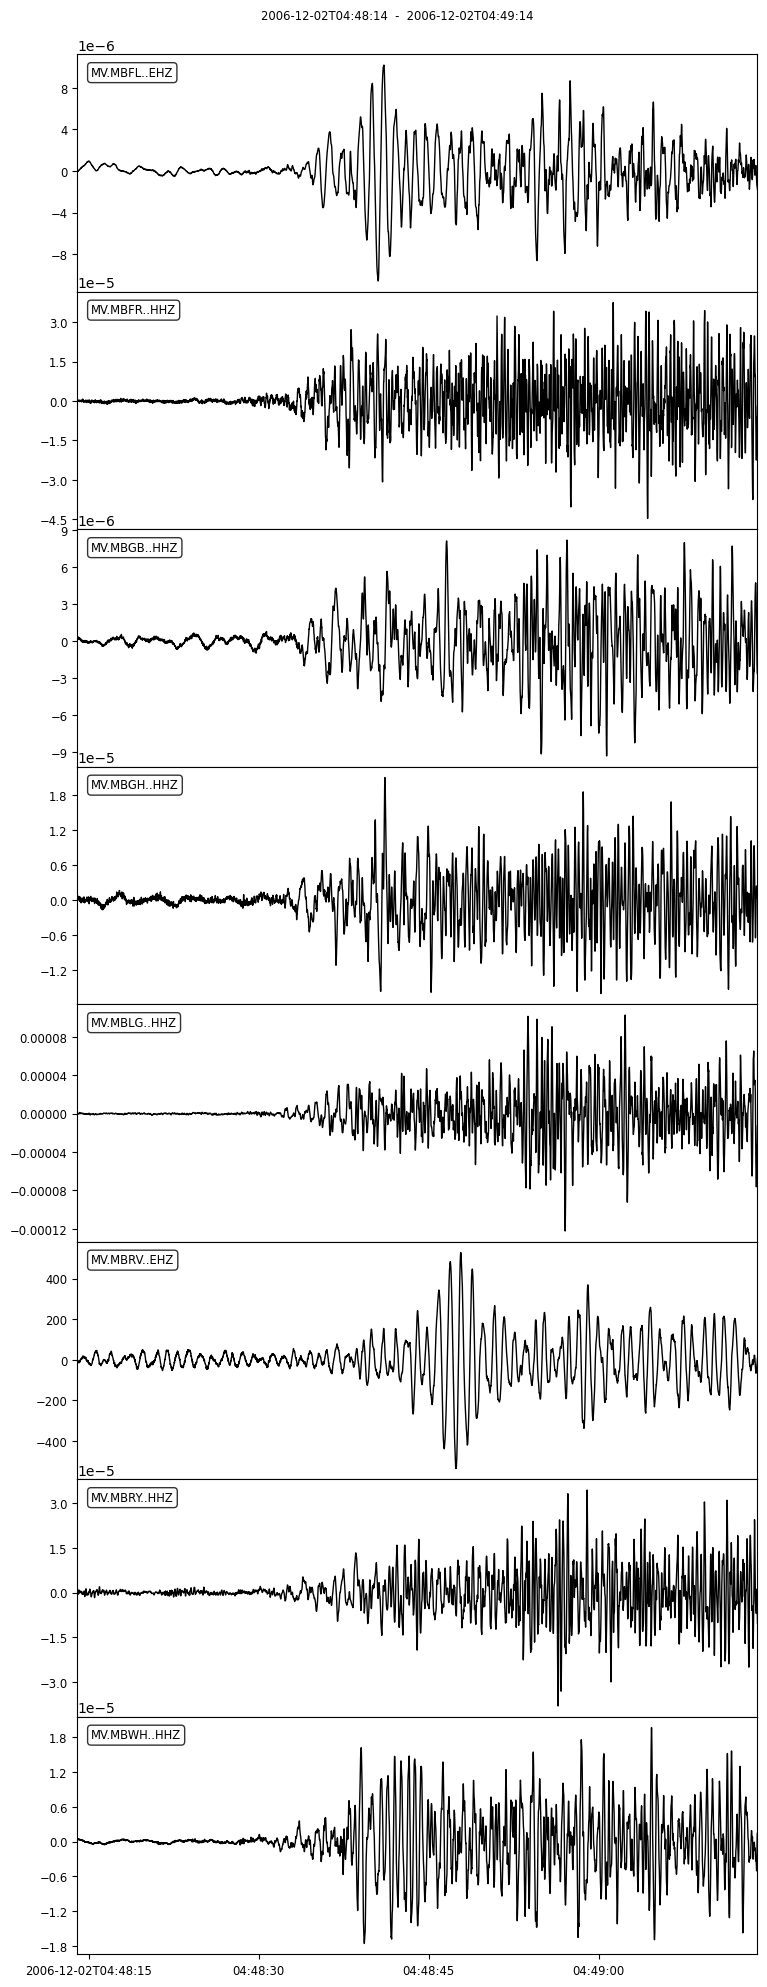

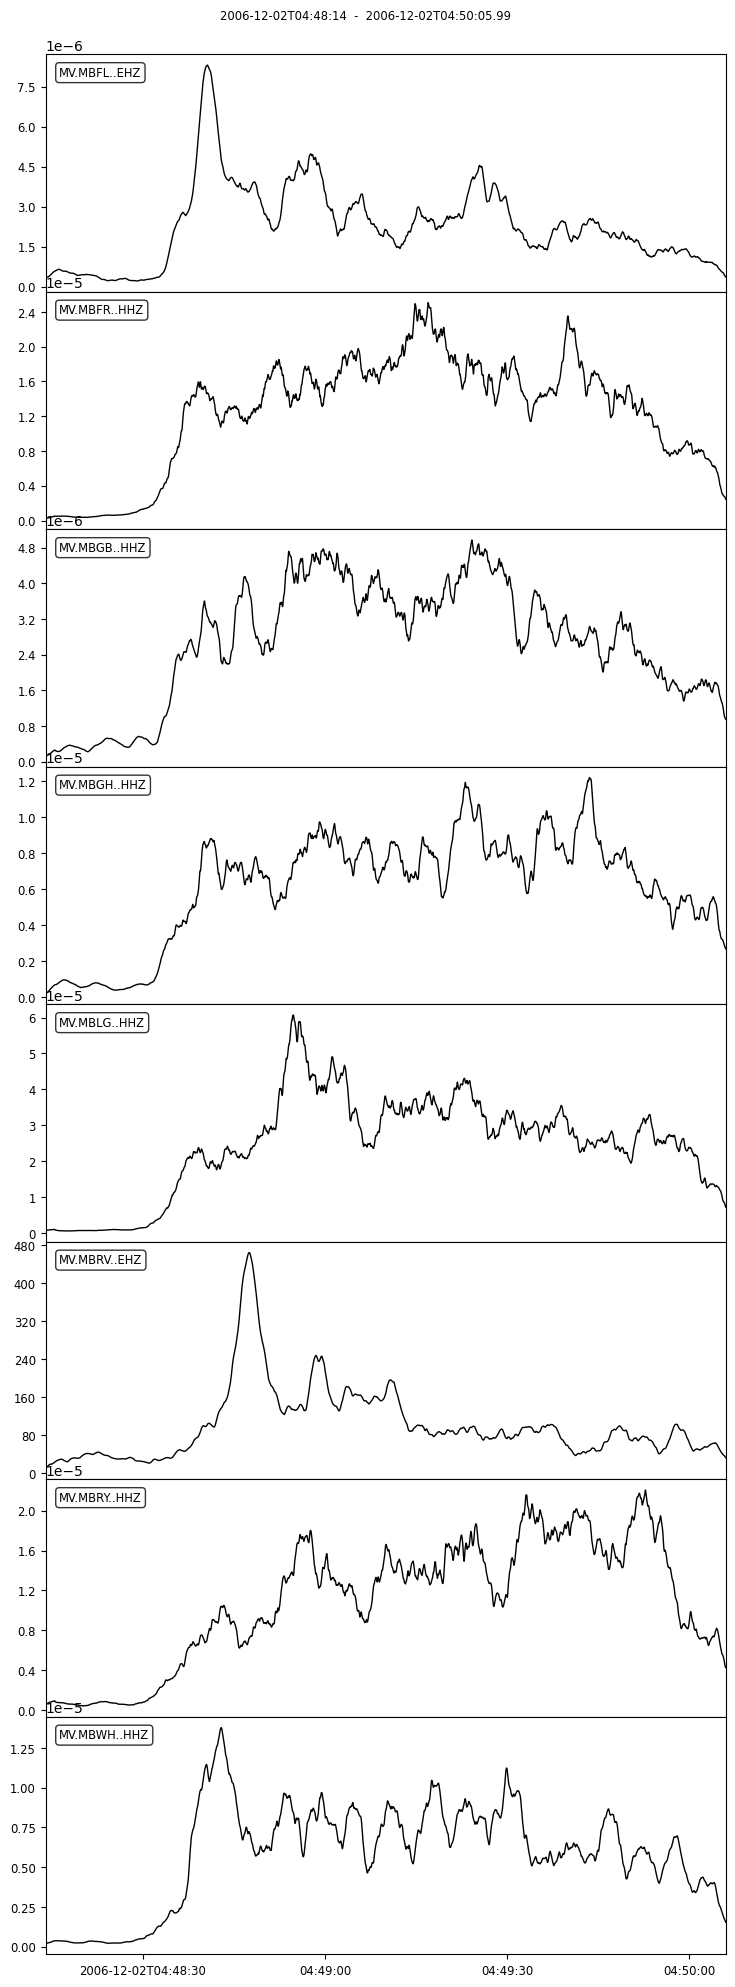

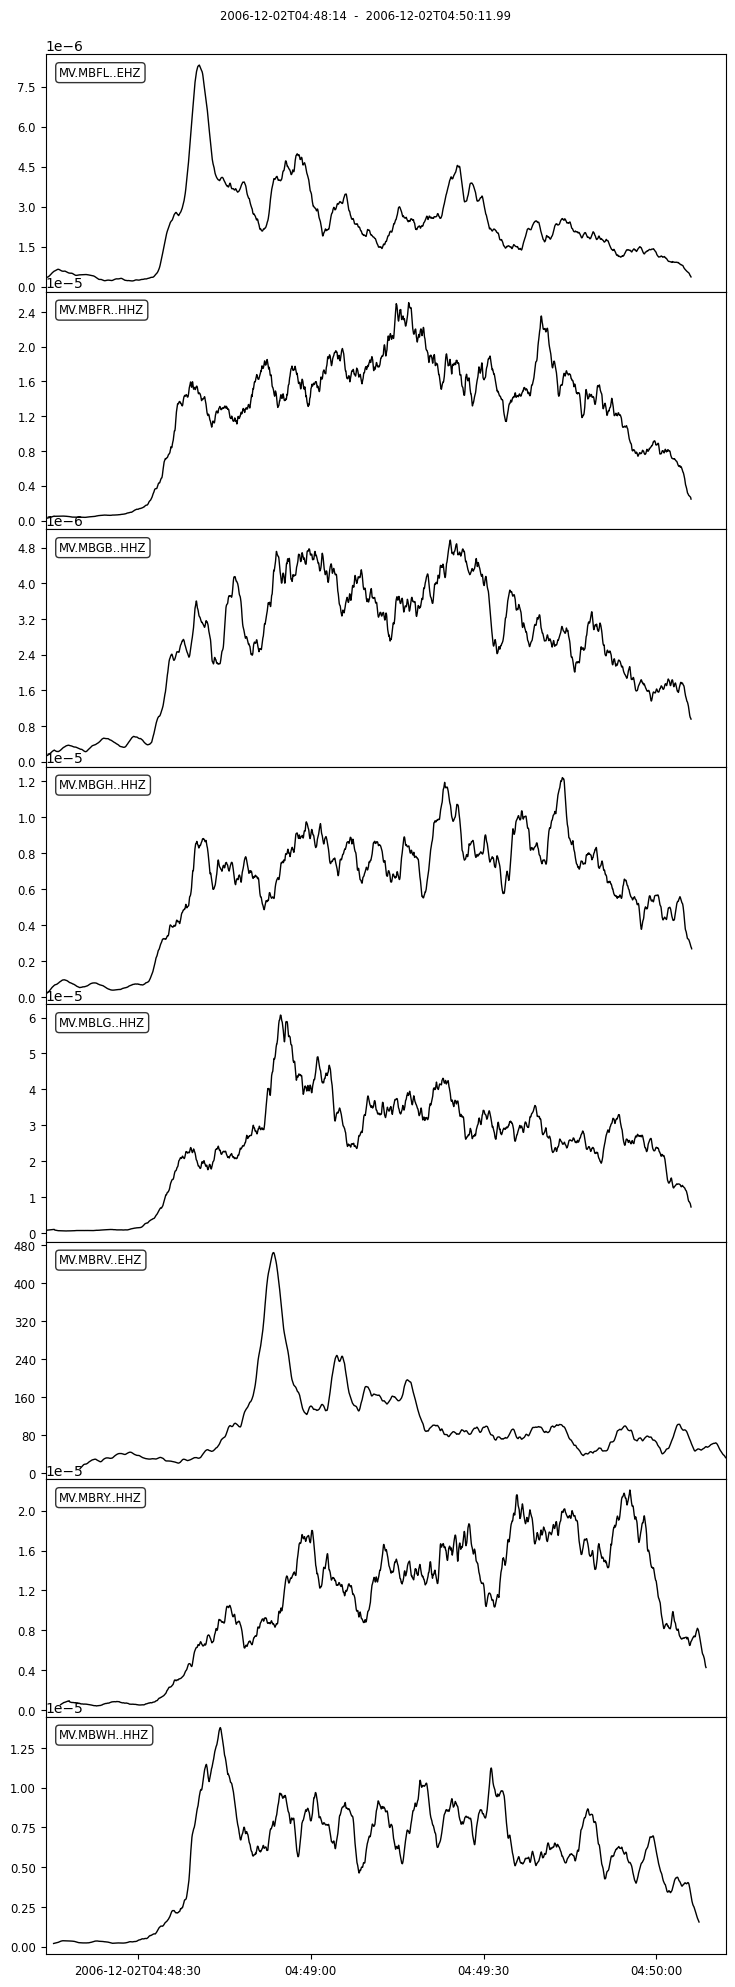

Applied lags (s): {'MBFL': 0.0, 'MBFR': -0.0, 'MBGB': -0.0, 'MBGH': 0.11, 'MBLG': -0.0, 'MBRV': 6.0, 'MBRY': 2.6, 'MBWH': 1.39}


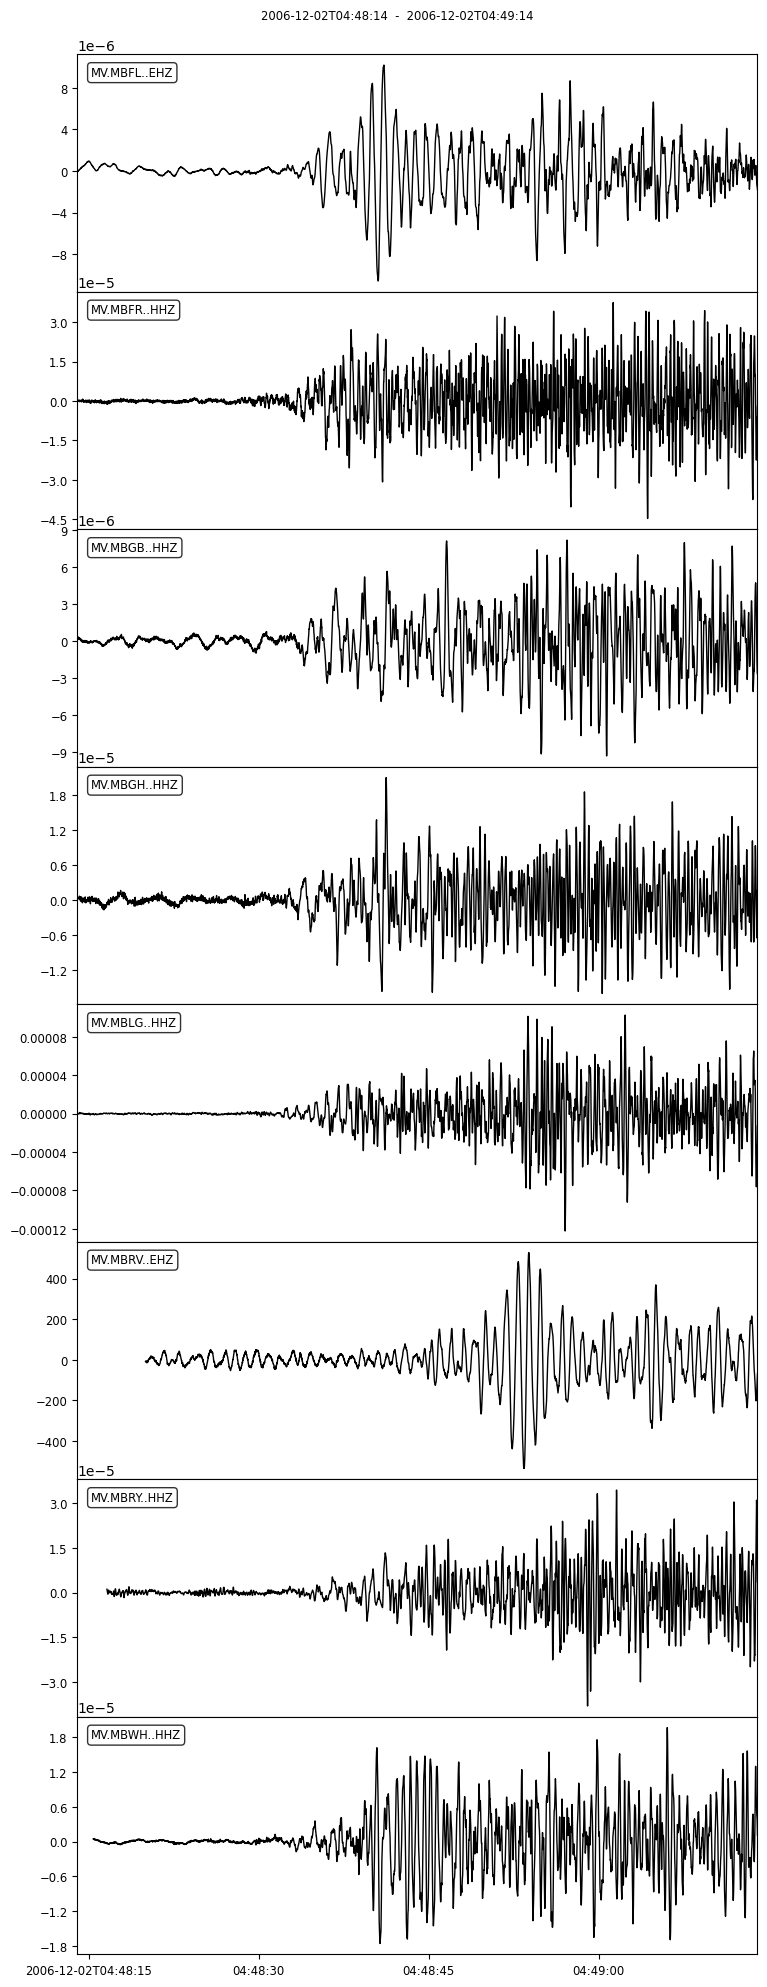

In [ ]:
from obspy import read
from flovopy.processing.envelopes import align_waveforms, align_waveforms_global, locate_with_grid_from_delays
from flovopy.asl.grid import Grid
from flovopy.asl.distances import compute_or_load_distances  # already in your codebase

# Load and preprocess as you already do:
st = read(str(event_files[116])).select(component="Z")
st.merge(fill_value='interpolate')
st.detrend("linear")

# Quick visual (unchanged)
st.plot(equal_scale=False, endtime=st[0].stats.starttime + 40)

# --- Simple reference-based alignment (kept for convenience) ---
aligned_st, lags = align_waveforms(
    st, max_lag_s=6.0, smooth_s=3.0, decimate_to=None
)
print("Applied lags (s):", lags)
aligned_st.plot(equal_scale=False, endtime=st[0].stats.starttime + 60)

# --- Global alignment (recommended) ---
aligned_st, lags, delays = align_waveforms_global(
    st, max_lag_s=20.0, min_corr=0.25, smooth_s=0.5, decimate_to=25.0
)

# --- Optional: locate using your grid (consistent with enveloc philosophy) ---
gridobj = Grid.load(GRIDFILE_DEFAULT)

# If you want node→station distances explicitly (not required here, locate wrapper calls it):
# node_distances_km, coords, meta = compute_or_load_distances(gridobj, inventory=inv, stream=st)

result = locate_with_grid_from_delays(
    gridobj,
    inventory=inv,      # your ObsPy Inventory
    delays=delays,
    stream=st,
    c_range=(0.4, 3.0),
    n_c=61
)

print(f"Best node #{result.get('node')}  c≈{result.get('speed', float('nan')):.2f} km/s  "
      f"score={result.get('score', float('nan')):.3f}  pairs={result.get('n_pairs')}")
if 'lon' in result:
    print(f"~({result['lon']:.5f}, {result['lat']:.5f}), elev={result.get('elev_m', np.nan)} m")

# Run events from last cell, one event at a time, to check it works

In [ ]:
# --- Run ASL per event (cell 6) ---
summaries: List[Dict[str, Any]] = []

for i, ev in enumerate(selected_files, 1):
    print(f"[{i}/{len(event_files)}] {ev}")
    result = run_single_event(
        mseed_file=str(ev),
        cfg=cfg,
        refine_sector=False,
        station_gains_df=None,
        topo_kw=topo_kw,
        debug=True,
    )
    summaries.append(result)

# Summarize
df = pd.DataFrame(summaries)
display(df)

summary_csv = Path(OUTPUT_DIR) / f"{cfg.tag()}__summary.csv"
df.to_csv(summary_csv, index=False)
print(f"Summary saved to: {summary_csv}")

if not df.empty:
    n_ok = int((~df.get("error").notna()).sum()) if "error" in df.columns else len(df)
    print(f"Success: {n_ok}/{len(df)}")


# Run all events efficiently

In [ ]:
print(INPUT_DIR)
print(cfg)
print(topo_kw)
print(REFINE_SECTOR)
'''
run_all_events(
    input_dir=INPUT_DIR,
    station_gains_df = None,
    cfg=cfg,
    refine_sector=REFINE_SECTOR,
    topo_kw=topo_kw,
    debug=True,
    max_events=999999,
    use_multiprocessing=True,
    workers=4,
)
'''

# Run Monte Carlo sweep of parameters for 1 event


In [ ]:
icewebSpectrogram(st).plot(fmin=0.1, fmax=10.0, log=True, cmap='plasma', dbscale=False)

#outfile=None, secsPerFFT=None, fmin=0.5, fmax=20.0, log=False, cmap=pqlx, clim=None, equal_scale=False, title=None, add_colorbar=True, precompute=False, dbscale=False, trace_indexes=[] ): 

In [ ]:

from flovopy.asl.wrappers2 import run_event_monte_carlo
from flovopy.processing.sam import VSAM, DSAM
'''
# Simple 6-draw sweep (replace with your own priors/sequences)
configs = ASLConfig.generate_config_list(
    inventory=None,
    output_base=None,
    gridobj=None,
    global_cache=None,      
    wave_kinds=("surface","body"),
    station_corr_tables=(station_corrections_df), #annual_station_corrections_df),
    speeds=(1.0, 3.0),
    Qs=(23, 1000),
    dist_modes=("3d",), # 2d needs a different grid and different distance and amplitude corrections
    misfit_engines=("l2","r2", "lin"),
    peakfs=(2.0, 8.0),
    window_seconds = 5.0, # change to be a tuple 10.0) not implemented yet
    min_stations = 5,
    sam_class = (VSAM), #, DSAM), # not implemented yet
    sam_metric = ("mean"),# "median", "rms", "VT", "LP"), # this doesn't seem to be implemented yet
    # context can be set later; set here if you like:
    debug=False,
)

configs = ASLConfig.generate_config_list(
    inventory=None,
    output_base=None,
    gridobj=None,
    global_cache=None,      
    wave_kinds=("surface",),
    station_corr_tables=(station_corrections_df), #annual_station_corrections_df),
    speeds=(1.0, 3.0),
    Qs=(23, 1000),
    dist_modes=("3d",), # 2d needs a different grid and different distance and amplitude corrections
    misfit_engines=("l2"),
    peakfs=(8.0),
    window_seconds = 5.0, # change to be a tuple 10.0) not implemented yet
    min_stations = 5,
    sam_class = (VSAM), #, DSAM), # not implemented yet
    sam_metric = ("mean"),# "median", "rms", "VT", "LP"), # this doesn't seem to be implemented yet
    # context can be set later; set here if you like:
    debug=False,
)


configs = ASLConfig.generate_config_list(    
    inventory=INV,
    output_base=str(OUTPUT_DIR),
    gridobj=gridobj,
    global_cache=GLOBAL_CACHE,
) 

print(len(configs))
'''


In [ ]:

# Shared run context
mseed_file   = event_files[116]
'''
results = run_event_monte_carlo(
    mseed_file=mseed_file,
    configs=configs,
    inventory=INV,
    output_base=str(OUTPUT_DIR),
    gridobj=gridobj,
    topo_kw=topo_kw,
    station_gains_df=None,
    parallel=False,
    max_workers=1,
    global_cache=GLOBAL_CACHE,
    debug=True,
)

# Inspect or summarize results as needed
n_ok = sum(1 for r in results if "error" not in r)
print(f"[MC] Completed {n_ok}/{len(results)} runs OK")
'''